In [1]:
using PyPlot
using Ananke
using TimerOutputs
#debug Timer
TimerOutputs.enable_debug_timings(Ananke)
Ananke.timeit_debug_enabled()

┌ Info: Precompiling Ananke [top-level]
└ @ Base loading.jl:1664


true

In [2]:
Nx,Ny,Nz = 2048,2048,1;
nx,ny,nz = 2048,2048,1;

Lx,Ly,Lz = [0,1],[0,1],[0,1];
nothingfunction(args...) = nothing;
prob = ProblemConstrcut(  ; N = (Nx,Ny,Nz),
                            n = (nx,ny,nz),
                           Lx = Lx,
                           Ly = Lx,
                           Lz = Lx,
                 SpatialOrder = 2,  
                   TimelOrder = 2,
                           T  = Float32,
                       Bfield = false,
                       Nghost = 4,
                      EOSType = "Adiabatic",
                     Boundary = ["Periodic","Periodic",
                                 "Periodic","Periodic",
                                 "Periodic","Periodic"],
                      usr_foo = nothingfunction)

MHDFlows Problem
  │    Features
  |     ├──────────── EOS: Adiabatic
  │     ├──────── B-field: OFF
  ├─────├── spatial Order: 2
  │     ├───── time Order: 2
  │     ├───── resolution: (2048, 2048, 1)
  │     └─────── boundary:  x₁(L/R) ("Periodic", "Periodic")
  │                         x₂(L/R) ("Periodic", "Periodic")
  │                         x₃(L/R) ("Periodic", "Periodic")
  │     Setting                                            
  │     ├─────────── grid: grid (on GPU)
  │     ├─────────── flux: flux
  │     ├── user function: usr_func
  └─────├─ conserved Vars: sol.U
        ├─primitived Vars: sol.W
        └────────── clock: clock


In [3]:
function pgen_KH!(prob)
   
  grid     = prob.grid;
  nx,ny,nz = grid.Nx,grid.Ny,grid.Nz;
  x1,x2,x3 = grid.x1,grid.x2,grid.x3;
    
    
  IDN,IEN,IPR  = prob.grid.ind.ρ ,prob.grid.ind.e ,prob.grid.ind.P;
  IVX,IVY,IVZ  = prob.grid.ind.v₁,prob.grid.ind.v₂,prob.grid.ind.v₃;  
    
  P = zeros(eltype(grid),size(prob.sol.U)[1:3]);
  ρ = zeros(eltype(grid),size(prob.sol.U)[1:3]);
  v  = zeros(eltype(grid),size(prob.sol.U)[1:3]);
  vy = zeros(eltype(grid),size(prob.sol.U)[1:3]);
    
  ρL = 2.0;
  PL = 2.5;
  vL = 0.5;
    
  ρR = 1.0;
  PR = 2.5;
  vR =-0.5;
  AS = 1e-2
  σ  = 0.1;
  Lx = (prob.grid.Lx_ed - prob.grid.Lx_st);
  Ly = (prob.grid.Ly_ed - prob.grid.Ly_st);
  
  x = Array(x1.x1f);
  y = Array(x2.x2f);
  
  @. ρ[:,:,:] = ρR
  @. P[:,:,:] = PR
  @. v[:,:,:] = vR
  @. ρ[:, 0.25 .<y.< 0.75, :] = ρL
  @. P[:, 0.25 .<y.< 0.75, :] = PL
  @. v[:, 0.25 .<y.< 0.75, :] = vL
  
  AR = 1e-3*(rand() - 0.5);
  Ψ  = @. exp(-0.5*(cos.(2π.*y/Ly)/(2π*σ/Ly))^2); 
  δy = @. (AS*sin(2π.*x/Lx) + AR)*Ψ
  @. vy += δy;
   
  SetUpProblemIC!(prob;  ρ = ρ,  p = P, ux = v, uy = vy)
  return nothing
    
end

pgen_KH! (generic function with 1 method)

In [4]:
pgen_KH!(prob)

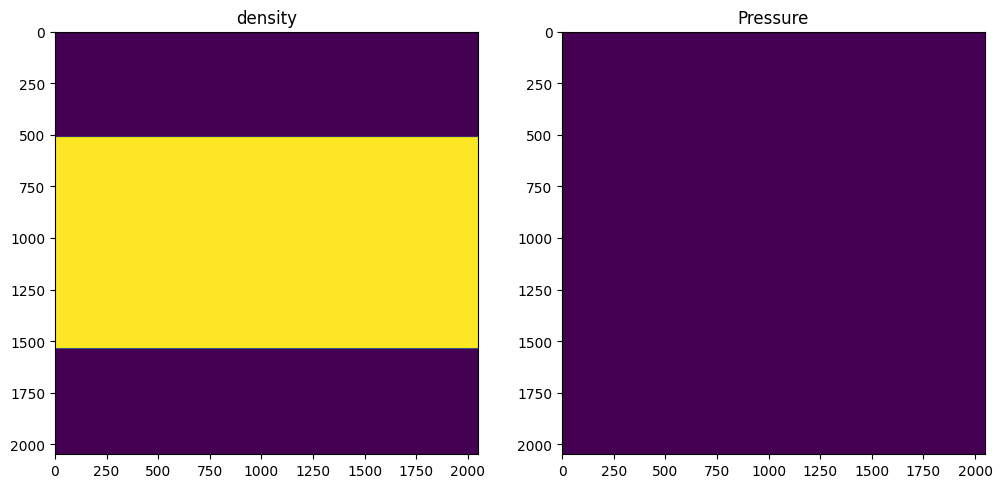

PyObject <matplotlib.image.AxesImage object at 0x7f97240076d8>

In [5]:
w = prob.sol.W;
IDN,IEN,IPR  = prob.grid.ind.ρ::Int ,prob.grid.ind.e::Int ,prob.grid.ind.P::Int ;
IVX,IVY,IVZ  = prob.grid.ind.v₁::Int,prob.grid.ind.v₂::Int,prob.grid.ind.v₃::Int;
is,ie = prob.grid.x1.is::Int,prob.grid.x1.ie::Int;
js,je = prob.grid.x2.js::Int,prob.grid.x2.je::Int;
ks,ke = prob.grid.x3.ks::Int,prob.grid.x3.ke::Int;

figure(figsize=(12,6))
subplot(121);
d = Array(@view w[is:ie,js:je,ks,IDN]);
title("density")
imshow(d')
subplot(122);
d = Array(@view w[is:ie,js:je,ks,IPR]);
title("Pressure")
imshow(d')

In [6]:
reset_timer!(prob.debugTimer)
TimeIntegrator!(prob, 1.0,  200000;
                      usr_dt = 0.0,
                    CFL_Coef = 0.3,
                       diags = [],
                 loop_number = 100, 
                        save = false,
                    save_loc = "",
                    filename = "",
                 file_number = 0,
                     dump_dt = 0)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/doraho/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Simulation in rogress :   7%|▆         |  ETA: 1:14:45 (24.13 ms/it)
  Progress:  iter/Nₒ = 14154/200000, t/t₀ = 1.0/1.0

Total CPU/GPU time run = 341.579 s,Mzone update per second = 173.824 


In [9]:
prob.debugTimer

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:             344s /  98.8%           6.59GiB /  93.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 Time Stepper           14.2k     319s   93.7%  22.5ms   4.77GiB   77.2%   353KiB
   Flux intregation     28.3k     273s   80.3%  9.64ms   2.74GiB   44.3%   101KiB
     Solver dir x       28.3k    72.0s   21.2%  2.54ms    443MiB    7.0%  16.0KiB
     Solver dir y       28.3k    70.1s   20.6%  2.48ms    259MiB    4.1%  9.37KiB
     Adding ∂F∂x        28.3k    42.0s   12.4%  1.48ms    606MiB    9.6%  21.9KiB
     Reconstruct dir x  28.3k    41.9s   12.3%  1.48ms    514MiB    8.1%  18.6KiB
     Reconstruc

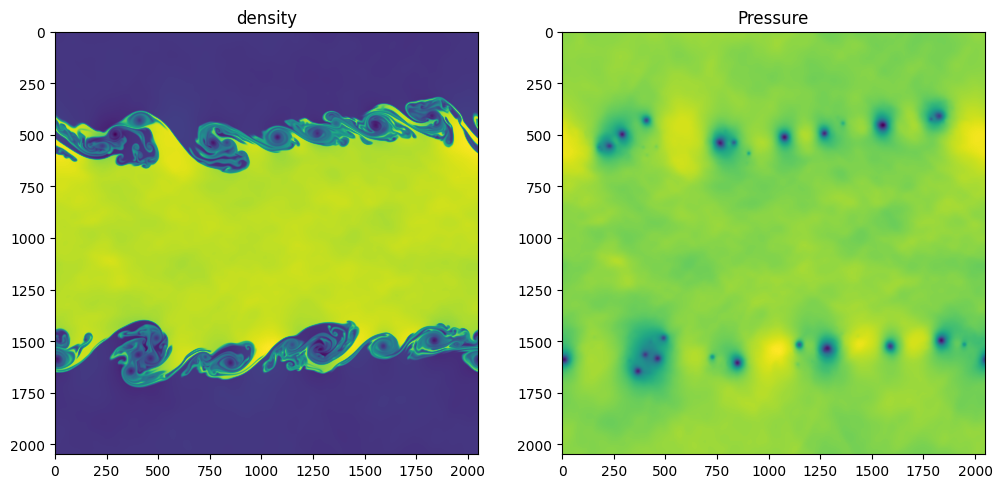

PyObject <matplotlib.image.AxesImage object at 0x7f96cf36ca58>

In [10]:
w = prob.sol.W;

figure(figsize=(12,6))
subplot(121);
d = Array(@view w[is:ie,js:je,ks,IDN]);
title("density")
imshow(d')
subplot(122);
d = Array(@view w[is:ie,js:je,ks,IPR]);
title("Pressure")
imshow(d')